In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch

from torch.distributions import Dirichlet
from tqdm.autonotebook import tqdm
from rxitect.gflownet.models.frag_graph_gfn import FragBasedGraphGFN
from rxitect.gflownet.contexts.frag_graph_context import FragBasedGraphContext
from rxitect.gflownet.utils.graph_sampler import GraphSampler
from rxitect.gflownet.contexts.envs.graph_building_env import GraphBuildingEnv
from rxitect.gflownet.tasks.a import thermometer

In [2]:
model_state = torch.load("../logs/mogfn/drugex_synth_v2_tb_beta_96_lr_5e-4_nosascore/model_state.pt")

In [3]:
state_dict, hps = model_state["models_state_dict"][0], model_state["hps"]

In [4]:
ctx = FragBasedGraphContext(num_cond_dim=hps["num_cond_dim"])
gfn = FragBasedGraphGFN(ctx=ctx, estimate_init_state_flow=True)

In [5]:
gfn.load_state_dict(state_dict=state_dict)
gfn.eval();

In [6]:
env = GraphBuildingEnv(ctx=ctx)
sampler = GraphSampler(ctx, env, max_steps=None, max_nodes=9, rng=np.random.default_rng(123), random_action_prob=hps["random_action_prob"])

In [7]:
def generate_encoded_ci(n: int, num_prefs: int, rexp_distribution = (96, 96), rng = np.random.default_rng(123)):
    beta = rng.uniform(*rexp_distribution, n).astype(np.float32)
    upper_bound = rexp_distribution[1]
    beta_enc = thermometer(torch.tensor(beta), 32, 0, upper_bound)  # TODO: hyperparameters
    m = Dirichlet(torch.FloatTensor([1.] * num_prefs))
    preferences = m.sample([n])
    encoding = torch.cat([beta_enc, preferences], 1)
    info = {'beta': torch.tensor(beta), 'encoding': encoding, 'preferences': preferences}
    return info


def replenish_stems(g, ctx):
    if hasattr(ctx, "frags_stems"):
        for i in g.nodes:
            g.nodes[i]['stems'] = ctx.frags_stems[g.nodes[i]['v']]
    else:
        raise ValueError("This context does not use stems")
        
        
def trajs_to_mols(trajs, ctx):
    graphs = []
    for t in trajs:
        G = t["traj"][-1][0]
        replenish_stems(G, ctx)
        graphs.append(G)
    mols = [ctx.graph_to_mol(G) for G in graphs]
    return mols

In [8]:
sampled_mols = []
total_samples = 100_000
batch_size = 500


for _ in tqdm(range(total_samples // batch_size), desc=f"Sampling {batch_size} trajectories..."):
    n_samples = batch_size
    ci = generate_encoded_ci(n=n_samples, num_prefs=4)
    res = sampler.sample_from_model(model=gfn, n=n_samples, cond_info=ci["encoding"], device="cpu")
    mols = trajs_to_mols(res, ctx)
    sampled_mols.extend(mols)

Sampling 500 trajectories...:   0%|          | 0/200 [00:00<?, ?it/s]

In [9]:
from rxitect.scorers.a2ascore import Predictor


a2a = Predictor(path="../models/RF_REG_CHEMBL251.pkg")
a1 = Predictor(path="../models/RF_REG_CHEMBL226.pkg")
herg = Predictor(path="../models/RF_REG_CHEMBL240.pkg")

In [10]:
enhanced_fps = Predictor.calc_fp(mols=sampled_mols)

In [11]:
a2ascore_preds = a2a(enhanced_fps)
a2ascore_preds = torch.from_numpy(a2ascore_preds.astype(np.float32))
a2ascore_preds = (a2ascore_preds / 8.8).clamp(0, 1)

In [12]:
a1_score_preds = a1(enhanced_fps)
a1score_preds = torch.from_numpy(a1_score_preds.astype(np.float32))
a1score_preds = (a1score_preds / 8.6).clamp(0, 1)

In [13]:
herg_score_preds = herg(enhanced_fps)
herg_preds = torch.from_numpy(herg_score_preds.astype(np.float32))
herg_preds = 1-(herg_preds / 7.4).clamp(0, 1)

<AxesSubplot: ylabel='Density'>

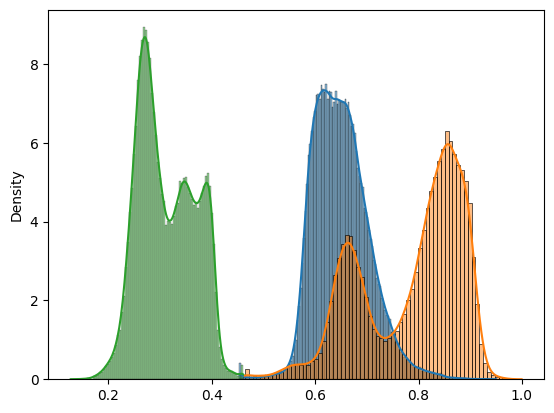

In [14]:
sns.histplot(a2ascore_preds, stat="density", kde=True)
sns.histplot(a1score_preds, stat="density", kde=True)
sns.histplot(herg_preds, stat="density", kde=True)


In [15]:
from rdkit import Chem

sampled_smiles = [Chem.MolToSmiles(m) for m in tqdm(sampled_mols, desc="Transforming RDKit Mols to SMILES")]

Transforming RDKit Mols to SMILES:   0%|          | 0/100000 [00:00<?, ?it/s]

In [16]:
pd.Series(sampled_smiles).to_csv("../reports/rascore_case_gfn_tb_beta96_100K.txt", header=None, index=False)

In [17]:
len(list(set(sampled_smiles)))

99972

In [18]:
prev = pd.read_csv("../reports/base_case_gfn_tb_beta96_100K.txt", header=None)

In [21]:
len(list(set(prev[0])))

99988

In [22]:
n_samples = 50
ci = generate_encoded_ci(n=n_samples, num_prefs=4)
res = sampler.sample_from_model(model=gfn, n=n_samples, cond_info=ci["encoding"], device="cpu")
extra_mols = trajs_to_mols(res, ctx)

In [23]:
len(extra_mols)

50

In [24]:
extra_smiles = [Chem.MolToSmiles(m) for m in extra_mols]

In [25]:
total_smiles = sampled_smiles + extra_smiles

In [28]:
total_smiles_unique = (list(set(total_smiles)))

In [29]:
pd.Series(total_smiles_unique).to_csv("../reports/rascore_case_gfn_tb_beta96_100022_unique.txt", header=None, index=False)